# EPC Anlaysis for Wales Properties


### What Do We Want to Find?

In this notebook, we analyse and plot the energy efficiency and household emissions for housing properties in Wales. We put a special focus on the difference between the different sectors: social and private rented and owner-occupied.

For the full report and analysis on Wales emissions and energy efficiency across sectors, please consult this document [here](https://docs.google.com/document/d/1jIx0sU0esqO86-T3qv6VTc9kdpk6pQ7472KRC2rj5RU/edit#heading=h.on1g77x0j864).

Using iPython widgets, you can easily adjust the settings and generate plots for all kinds of computations of features.

### Structure of this Notebook<a id='top'></a>


- [Data Loading and Preprocessing](#loading)
    - Select subset of EPC dataset (area and features)
    - Load the EPC data for Wales
    - Load Index of Multiple Deprivation data for Wales
    - Merge dataframes on basis of postcodes
        
        
- [EPC Ratings](#epc_ratings)  
    - Create additional EPC features
    - Plot EPC Rating Distribution for Different Sectors
    - Plot Energy Rating for All Sectors at once
    - Plot Potential Energy Rating Increase for Different Sectors
    - Plot Distribution of EPC Ratings and other Features
    
    
- [Index of Multiple Deprivation Wales (WIMD](#wimd)
    - Plot Index of Multiple Deprivation by Sectors
    - Plot Distribution of EPC Ratings by IMD Quartiles
    - Correlation Check between Energy Efficiency and IMD 
    

- [Heating, Water and Insulation Efficiency](#heating)
    - Plot Efficiency Features by Sectors
    - Plot Efficiency Features by IMD
    - Create new Heating Features
    - Plot Heating System and Source by Sectors


- [CO2 Emissions](#emissions)

    - Plot CO2 Emissions by Sectors and IMD Decile


- [Further Analysis](#other)

    - Plot Histogram for any Feature
    - Plot Feature by Sectors
    - Plot Subcategories by other Subcategories
    
   

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import re

from epc_data_analysis.getters import epc_data, util_data
from epc_data_analysis.pipeline import feature_engineering, easy_plotting, epc_analysis
from epc_data_analysis.analysis.notebooks.notebook_utils import my_widgets

## Data Loading and Preprocessing<a id='loading'></a>
[[back to top]](#top)

    - Select subset of EPC dataset (area and features)
    - Load the EPC data for Wales
    - Load Index of Multiple Deprivation data for Wales
    - Merge dataframes on basis of postcodes
 
 

### Select Subset of EPC data
Select the part of the UK for which to load EPC data and select the features of interest. Loading all features at once is not recommended as it considerably slows down processing. 

In [2]:
# Display dataset widgets
display(my_widgets.UK_part_widget)
display(my_widgets.feature_widget)

Dropdown(description='Part of UK', options=('Wales', 'England', 'all'), value='Wales')

SelectMultiple(description='EPC Dataset Columns', index=(6, 7, 8, 87, 65, 66, 47, 48, 50, 51, 53, 54, 56, 57, …

### Load EPC data

Load EPC data subset according to settings. Furthermore, remove all samples with `NO DATA!` as TENURE value  (only 0.84%) since we are especially interested in this feature and don't want to consider features with no tenure data.

In [3]:
# Get parameters from widgets
UK_part = my_widgets.UK_part_widget.value
features_of_interest = list(my_widgets.feature_widget.value)

# Load Wales EPC data
epc_df = epc_data.load_EPC_data(subset=UK_part, usecols=features_of_interest, low_memory=False)
epc_df.head()

# Remove samples with NO DATA! on tenure type
epc_df = epc_df[epc_df.TENURE != "NO DATA!"]
epc_df.head()

/Users/juliasuter/opt/anaconda3/envs/epc_data_analysis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,POSTCODE,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,...,ROOF_ENERGY_EFF,ROOF_ENV_EFF,MAINHEAT_DESCRIPTION,MAINHEAT_ENERGY_EFF,MAINHEAT_ENV_EFF,MAINHEATC_ENERGY_EFF,MAINHEATC_ENV_EFF,LIGHTING_ENERGY_EFF,LIGHTING_ENV_EFF,TENURE
0,NP7 6BG,C,C,76,2.5,31.0,47.0,47.0,393.0,374.0,...,Good,Good,"Boiler and radiators, mains gas",Good,Very Good,Average,Average,Very Good,Very Good,owner-occupied
1,NP26 3LW,C,B,72,2.1,33.0,57.0,44.0,374.0,343.0,...,Good,Good,"Boiler and radiators, mains gas",Good,Good,Average,Average,Very Good,Very Good,owner-occupied
2,NP15 1AE,D,C,62,5.3,44.0,124.0,67.0,736.0,566.0,...,Average,Average,"Boiler and radiators, mains gas",Good,Good,Average,Average,Poor,Poor,owner-occupied
3,NP16 5LY,D,B,64,3.9,45.0,72.0,55.0,716.0,492.0,...,Good,Good,"Boiler and radiators, mains gas",Good,Good,Good,Good,Very Good,Very Good,owner-occupied
4,NP26 3PR,C,B,75,3.1,26.0,91.0,62.0,672.0,562.0,...,Good,Good,"Boiler and radiators, mains gas",Good,Good,Average,Average,Good,Good,owner-occupied


### Load IMP (Index of Multiple Deprivation)

Load IMP data and merge datasets using the POSTCODE feature.

In [4]:
# Load Wales IMD data
wimd_df = util_data.get_WIMD_data()

# Merge datasets 
epc_wimd_df = util_data.merge_dataframes(epc_df, wimd_df, "POSTCODE")
epc_wimd_df.head()

,POSTCODE,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,...,LIGHTING_ENV_EFF,TENURE,LSOA,WIMD Rank,WIMD Decile,LATITUDE,LONGITUDE,WIMD Score,WIMD Quintile,WIMD Quartile
0,NP76BG,C,C,76,2.5,31.0,47.0,47.0,393.0,374.0,...,Very Good,owner-occupied,W01001558,676,4,51.830316,-3.014073,23.5,2,2
1,NP76BG,D,C,59,5.9,59.0,69.0,69.0,1039.0,793.0,...,Very Good,owner-occupied,W01001558,676,4,51.830316,-3.014073,23.5,2,2
2,NP76BG,C,B,73,3.0,36.0,98.0,55.0,530.0,492.0,...,Poor,rental (social),W01001558,676,4,51.830316,-3.014073,23.5,2,2
3,NP76BG,D,B,59,5.9,59.0,70.0,70.0,1030.0,655.0,...,Very Good,owner-occupied,W01001558,676,4,51.830316,-3.014073,23.5,2,2
4,NP76BG,D,B,61,5.3,57.0,72.0,72.0,908.0,542.0,...,Very Good,owner-occupied,W01001558,676,4,51.830316,-3.014073,23.5,2,2


## EPC Ratings <a id='epc_ratings'></a> 
[[back to top]](#top)
    
    - Create additional EPC features
    - Plot EPC Rating Distribution for Different Sectors
    - Plot Energy Rating for All Sectors at once
    - Plot Potential Energy Rating Increase for Different Sectors
    - Plot Distribution of EPC Ratings and other Features
    
    
### Create additional EPC features

`CURR_ENERGY_RATING_NUM`: represents EPC rating (A-H) in number instead of letter (A --> 7, B --> 6 etc.)
This is helpful for computing the difference between two ratings or the average potential increase.

`DIFF_POT_ENERGY_RATING`: represents the difference between the current and the potential energy rating as a number (e.g. 2 if increase from D to B is impossible).


In [5]:
# Add new features
epc_wimd_df = feature_engineering.get_new_EPC_rating_features(epc_wimd_df)
epc_wimd_df.head()

,POSTCODE,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,...,WIMD Rank,WIMD Decile,LATITUDE,LONGITUDE,WIMD Score,WIMD Quintile,WIMD Quartile,CURR_ENERGY_RATING_NUM,ENERGY_RATING_CAT,DIFF_POT_ENERGY_RATING
0,NP76BG,C,C,76,2.5,31.0,47.0,47.0,393.0,374.0,...,676,4,51.830316,-3.014073,23.5,2,2,5,C-D,0
1,NP76BG,D,C,59,5.9,59.0,69.0,69.0,1039.0,793.0,...,676,4,51.830316,-3.014073,23.5,2,2,4,C-D,1
2,NP76BG,C,B,73,3.0,36.0,98.0,55.0,530.0,492.0,...,676,4,51.830316,-3.014073,23.5,2,2,5,C-D,1
3,NP76BG,D,B,59,5.9,59.0,70.0,70.0,1030.0,655.0,...,676,4,51.830316,-3.014073,23.5,2,2,4,C-D,2
4,NP76BG,D,B,61,5.3,57.0,72.0,72.0,908.0,542.0,...,676,4,51.830316,-3.014073,23.5,2,2,4,C-D,2


### Plot EPC Rating Distribution for Different Sectors

The social rental sector shows on average the highest EPC ratings, with C being the most common category.

In [6]:
@interact(tenure_type=my_widgets.tenure_type_widget)
def plot_EPC_rating_by_sectors(tenure_type):

    easy_plotting.plot_feature_by_subcategories(
        epc_wimd_df,
        "CURRENT_ENERGY_RATING",
        "TENURE",
        tenure_type,
        plot_kind="bar",
    )

interactive(children=(Dropdown(description='Tenure Type', options=('rental (social)', 'rental (private)', 'own…

### Plot Energy Rating for All Sectors at once

The social rental sector shows on average the highest EPC ratings, with C being the most common category. The private rental sector has slightly worse average ratings with an average rating of D. For the owner-occupied sector the ratings D and E are most common.

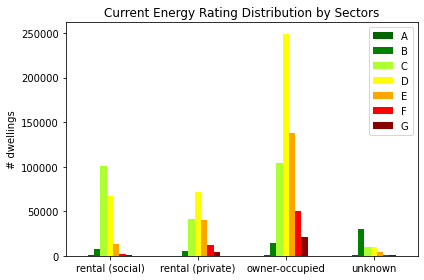

In [7]:
epc_rating_order = ["A", "B", "C", "D", "E", "F", "G"]
tenure_type_order = ["rental (social)", "rental (private)", "owner-occupied", "unknown"]
color_list = ["darkgreen", "green", "greenyellow", "yellow", "orange", "red", "darkred"]

# Plot Energy Rating Distribution by Sector
easy_plotting.plot_subcats_by_other_subcats(
        epc_wimd_df,
        "TENURE",
        "CURRENT_ENERGY_RATING", 
        feature_1_order=tenure_type_order,
        feature_2_order=epc_rating_order,
        y_label="# dwellings",
        plotting_colors=color_list,
        plot_title='Current Energy Rating Distribution by Sectors')

### Plot Potential Energy Rating Increase for Different Sectors

The social rented and owner-occupied sectors have higher potential for improving their EPC ratings since their current ratings are generally lower than for the social renter sector.

In [8]:
@interact(tenure_type=my_widgets.tenure_type_widget)
def plot_potential_EPC_difference_by_tenure_type(tenure_type):

    easy_plotting.plot_feature_by_subcategories(
        epc_wimd_df,
        "DIFF_POT_ENERGY_RATING",
        "TENURE",
        tenure_type,
        plot_kind="bar",
    )

interactive(children=(Dropdown(description='Tenure Type', options=('rental (social)', 'rental (private)', 'own…

### Plot Distribution of EPC Ratings and other Features

More than one third of all properties have the rating D. Every fourth property has rating C and every fifth property has rating E. The ratings B, F and G are rare. Rating A doesn't even cover 1% of all properties.

When looking at the potential EPC ratings, B and C cover 80% of all properties, showing a high potential higher energy efficiency.

You can also inspect other feature's distribution.

In [9]:
# Get all features from EPC dataset as widget
column_widgets = my_widgets.get_custom_widget(epc_wimd_df.columns, description="EPC feature", default_value="CURRENT_ENERGY_RATING", widget_type='dropdown')

@interact(category=column_widgets)
def plot_EPC_rarting_distribution(category):
    easy_plotting.plot_subcategory_distribution(
        epc_wimd_df, 
        category, 
        normalize=True, 
        y_label="# dwellings"
    )

interactive(children=(Dropdown(description='EPC feature', index=1, options=('POSTCODE', 'CURRENT_ENERGY_RATING…

## Index of Multiple Deprivation <a id='wimd'></a> 
[[back to top]](#top)
    
    - Plot Index of Multiple Deprivation by Sectors
    - Plot Distribution of EPC Ratings by IMD Quartiles
    - Correlation Check between Energy Efficiency and IMD 
    
    
*Note that a low IMD score signifies a more deprived area, while a high IMD score indicates less deprived areas.*
    
### Plot Index of Multiple Deprivation by Sectors

The social rental sector mainly consists of properties with low IMD scores. For the other two sectors, it's more balanced, with few properties from the least deprived areas for the private rental sector and few properties from the most deprived areas in the owner-occupied sector.

In [10]:
# The the order in which to display efficiency and color map
efficiency_order = ["Very Good", "Good", "Average", "Poor", "Very Poor"]
color_list = ["darkgreen", "green", "greenyellow", "yellow", "orange", "red", "darkred"]


@interact(feature=my_widgets.WIMD_widget)
def plot_IMD_by_sectors(feature):
    easy_plotting.plot_subcats_by_other_subcats(
        epc_wimd_df,
        "TENURE",
        feature,
        feature_1_order=tenure_type_order,
        y_label="# dwellings",
        plotting_colors="RdYlGn",
        plot_title='{} by tenure type'.format(feature))

interactive(children=(Dropdown(description='WIMD', options=('WIMD Decile', 'WIMD Quartile', 'WIMD Quintile', '…

### Plot Distribution of EPC Ratings by IMD Quartiles

The distribution of EPC ratings across different IMD (Index of Multiple Deprivation) Quartiles is very similar, with D being the most common category, followed by C and E. The IMD does not seem to considerably effect the EPC ratings.

In [11]:
@interact(quartile=my_widgets.quartile_type_widget)
def plot_EPC_by_IMD_quartile(quartile):

    easy_plotting.plot_feature_by_subcategories(
        epc_wimd_df,
        "CURRENT_ENERGY_RATING",
        "WIMD Quartile",
        quartile,
        plot_kind="bar",
        plot_title='Current Energy Rating for WIMD Quartile {}'.format(quartile)
    )

interactive(children=(Dropdown(description='WIMD Quartile', options=(1, 2, 3, 4), value=1), Output()), _dom_cl…

### Correlation Check between Energy Efficiency and IMD 

There is no signficant correlation between energy efficiency and IMD. There are probably many other factors that influence energy efficiency, for example location, area density, heating costs, age of building, and ‘who is in charge’. 

In [12]:
# Settings for widgets
social_rental_epc = epc_wimd_df.loc[epc_wimd_df["TENURE"] == "rental (social)"]
private_rental_epc = epc_wimd_df.loc[epc_wimd_df["TENURE"] == "rental (private)"]
owner_epc = epc_wimd_df.loc[epc_wimd_df["TENURE"] == "owner-occupied"]

feature_1 =  ['WIMD Score', 'WIMD Quartile', 'WIMD Quintile', 'WIMD Decile', 'WIMD Rank']

feature_2 = ['CURRENT_ENERGY_EFFICIENCY', 'CURR_ENERGY_RATING_NUM', 'CURRENT_ENERGY_RATING',
             'CO2_EMISSIONS_CURRENT']

df_subsets = ['all','social rental','private rental','owner-occupied']


@interact(df_subset=df_subsets, 
          feature_1=feature_1, feature_2=feature_2, 
          ylim_max=my_widgets.ylim_slider_widget, with_hist_subplots=True)
def check_for_correlation(df_subset, feature_1, feature_2, ylim_max, with_hist_subplots):

    # Select subset
    if df_subset == 'all':
        df = epc_wimd_df
    elif df_subset == 'social rental':
        df = social_rental_epc
    elif df_subset == 'private rental':
        df = private_rental_epc
    elif df_subset == 'owner-occupied':
        df = owner_epc
    else:
        raise IOError("Unknown subset '{}'".format(df_subset))
        
    # Plot correlation between feature 1 and feature 2
    easy_plotting.plot_correlation(df, feature_1, feature_2, ylim_max=ylim_max, 
                                   with_hist_subplots=with_hist_subplots)
        
    # Compute Pearson correlation between feature 1 and feature 2
    pearson_correlation = easy_plotting.get_pearson_correlation(df, feature_1, feature_2)
    print("Pearson Correlation:", round(pearson_correlation, 3))



interactive(children=(Dropdown(description='df_subset', options=('all', 'social rental', 'private rental', 'ow…

## Heating, Water and Insulation Efficiency<a id='heating'></a> 
[[back to top]](#top)

    - Plot Efficiency Features by Sectors
    - Plot Efficiency Features by IMD
    - Create new Heating Features
    - Plot Heating System and Source by Sectors

    
### Plot Efficiency Features by Sectors

For most sectors, "good" is the most frequent rating for the main heat energy efficiency, although the private rental and owner-occupied sector have considerably more properties with a rating of "average" or below.

You can also insepct other features. For instance, the walls energy efficiency is poor for many properties across sectors.

In [13]:
@interact(feature_2=my_widgets.efficiency_widget)
def plot_efficiency_by_sectors(feature_2):
    easy_plotting.plot_subcats_by_other_subcats(
        epc_wimd_df,
        "TENURE",
        feature_2,
        feature_1_order=tenure_type_order,
        feature_2_order=efficiency_order,
        y_ticklabel_type="k",
        plotting_colors=None,
        y_label="# dwellings"
    )

interactive(children=(Dropdown(description='Efficiency', options=('MAINHEAT_ENERGY_EFF', 'MAINHEAT_ENV_EFF', '…

### Plot Efficiency Features by IMD

As observed above, there is no strong correlation between energy efficiency and IMD so there are no signficant fluctuations in the energy efficiency across the different WIMD Deciles, Quartiles or Quintiles.

In [14]:
social_epc = epc_wimd_df.loc[epc_wimd_df["TENURE"] == "rental (social)"]

@interact(feature_1=my_widgets.WIMD_widget, feature_2=my_widgets.efficiency_widget)
def plot_efficiency_by_IMD(feature_1, feature_2):
    easy_plotting.plot_subcats_by_other_subcats(
        epc_wimd_df,
        feature_1,
        feature_2,
        feature_2_order=efficiency_order,
        y_ticklabel_type="k",
        plotting_colors=None,
        y_label="# dwellings"
    )
    


interactive(children=(Dropdown(description='WIMD', options=('WIMD Decile', 'WIMD Quartile', 'WIMD Quintile', '…

### Create new Heating Features

Features created on basis of free text feature `MAINHEAT_DESCRIPTION`.

`HEATING_SYSTEM`: Heating system (heat pump, underfloor heating, boiler and radiator etc.)

`HEATING_SOURCE`: Source energy for heating (electric, oil, gas, LPG)

------

`...EFF_AS_NUM`: The function *map_quality_to_number* generates numeric feature for efficiency features with values `very good` to `very poor`. 

For example, for `MAINHEAT_ENERGY_EFF` a new feature `MAINHEAT_ENERGY_EFF_AS_NUM` is created with numbers representing the efficiency instead of strings, e.g. `very good` --> 5 and `average` --> 3.

In [15]:
# Get new heating features
epc_wimd_df = feature_engineering.get_heating_features(epc_wimd_df)

# Generate numeric feature for mainheat efficiency (not used here)
epc_wimd_df = feature_engineering.map_quality_to_number(epc_wimd_df, ["MAINHEAT_ENERGY_EFF"])
epc_wimd_df.head()

,POSTCODE,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,LIGHTING_COST_CURRENT,LIGHTING_COST_POTENTIAL,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,...,LONGITUDE,WIMD Score,WIMD Quintile,WIMD Quartile,CURR_ENERGY_RATING_NUM,ENERGY_RATING_CAT,DIFF_POT_ENERGY_RATING,HEATING_SYSTEM,HEATING_SOURCE,MAINHEAT_ENERGY_EFF_AS_NUM
0,NP76BG,C,C,76,2.5,31.0,47.0,47.0,393.0,374.0,...,-3.014073,23.5,2,2,5,C-D,0,boiler and radiator,gas,4.0
1,NP76BG,D,C,59,5.9,59.0,69.0,69.0,1039.0,793.0,...,-3.014073,23.5,2,2,4,C-D,1,boiler and radiator,gas,4.0
2,NP76BG,C,B,73,3.0,36.0,98.0,55.0,530.0,492.0,...,-3.014073,23.5,2,2,5,C-D,1,boiler and radiator,gas,4.0
3,NP76BG,D,B,59,5.9,59.0,70.0,70.0,1030.0,655.0,...,-3.014073,23.5,2,2,4,C-D,2,boiler and radiator,gas,4.0
4,NP76BG,D,B,61,5.3,57.0,72.0,72.0,908.0,542.0,...,-3.014073,23.5,2,2,4,C-D,2,boiler and radiator,gas,4.0


### Plot Heating System and Source by Sectors

The boiler and radiator combi is by far the most common heating system while gas is clearly the most common heating source.

In [16]:
@interact(feature_1='TENURE', feature_2=['HEATING_SYSTEM','HEATING_SOURCE'], only_social_properties=False)
def plot_heating_system_and_source(feature_1, feature_2, only_social_properties):
    
    # Settings if only social properties are inspected
    if only_social_properties:
        selected_df = epc_wimd_df.loc[epc_wimd_df['TENURE'] == 'rental (social)']
        tenure_type_order = ["rental (social)"]
        
    # Settings if looking at all sectors
    else:
        selected_df = epc_wimd_df
        tenure_type_order = ["rental (social)", "rental (private)", "owner-occupied", "unknown"]
        
    # Set feature order for heating source
    if feature_2 == 'HEATING_SOURCE':
        feature_2_order=['oil','gas','LPG','electric','unknown']
    else:
        feature_2_order = None
        
    # Plot sector by heating feature
    easy_plotting.plot_subcats_by_other_subcats(
        selected_df,
        feature_1,
        feature_2,
        feature_1_order=tenure_type_order,
        feature_2_order=feature_2_order,
        y_ticklabel_type="k",
        y_label="# dwellings",
        plotting_colors="RdYlGn")

interactive(children=(Text(value='TENURE', description='feature_1'), Dropdown(description='feature_2', options…

## CO2 Emissions <a id='emissions'></a> 
[[back to top]](#top)
 
    - Plot CO2 Emissions by Sectors and IMD Decile


### Plot CO2 Emissions by Sectors and IMD Deciles

Emissions are lower in the rental sector than in the owner-occupied sector in Wales, even when normalising by the number of dwellings or by floor area.

The WIMD Deciles 5-7 have the highest CO2 Emissions, although there is no strong fluctuation across the different WIMD Deciles. 

In [17]:
@interact(feature_1=["CO2_EMISSIONS_CURRENT", "CO2_EMISS_CURR_PER_FLOOR_AREA"], 
          feature_2=['TENURE','WIMD Decile'])

def plot_CO2_emissions(feature_1, feature_2):
    
    # Get emission data and settings
    # ----------------------------------------------------
    
    emissions_dict = epc_analysis.get_emissions_info(epc_wimd_df, feature_1, feature_2) 
    
    descr_part_1 = "CO2 Emissions" if feature_1 == 'CO2_EMISSIONS_CURRENT' else 'CO2 Emissions per Floor Area'
    descr_part_2 = "by Tenure Type" if feature_2 == 'TENURE' else "by WIMD Decile"
    
    # Set tick roation and position
    x_tick_rotation, x_tick_ha = (45, 'right') if feature_2 == 'TENURE' else (0, 'center')
    
    # Where to save figures
    FIG_PATH = easy_plotting.FIG_PATH

    
    # Plot relative emissions
    # ----------------------------------------------------
        
    # Get relative emissions as bar plot
    emissions_dict["relative emissions"].plot(kind="bar", color="lightseagreen")

    
    # Get highest counter value for adjusting plot format
    highest_count = max([cty for cty in emissions_dict["relative emissions"].values])

    # Display count for every bar on top of bar
    ax = plt.gca()
    
    for i, cty in enumerate(emissions_dict["relative emissions"].values):
        ax.text(i, cty + highest_count/25, str(round(cty, 1)) + "%", horizontalalignment="center")

    # Adjust the ylimit of the plot 
    ax.set_ylim([0.0, highest_count+highest_count/5])
    
    #  Set title, ticks and labels
    plt.title("{} {} (%)".format(descr_part_1, descr_part_2))
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha)
    plt.xlabel("")
    
    # Set ylabel (with ompute total emissions)
    plt.ylabel("CO2 Emissions (%)\n(total of {}k tonnes/year)".format(
               str(round(emissions_dict["total"], 0))[:-3]))
    
    
    # Save and show
    plt.tight_layout()
    filename = "{} {} (relative)".format(descr_part_1, descr_part_2)
    filename = re.sub(" ", "_", filename)
    
    plt.savefig(FIG_PATH + filename)
    plt.show()
    
    
    # Plot absolute emissions
    # ----------------------------------------------------
    
    # Get absolute emissions as bar plot
    emissions_dict["absolute emissions"].plot(kind="bar", color="lightseagreen")

    # Get highest counter value for adjusting plot format
    highest_count = max([cty for cty in emissions_dict["absolute emissions"].values])
    
    # Set yticklabels
    ylabels, ax, division_int, division_type = easy_plotting.get_readable_tick_labels(plt, "k", "y")
    ax.set_yticklabels(ylabels)

    # Display count for every bar on top of bar
    ax = plt.gca()
    
    for i, cty in enumerate(emissions_dict["absolute emissions"].values):
        ax.text(i, cty + highest_count/25, str(int(cty / division_int)) + division_type, 
                horizontalalignment="center")

    # Adjust the ylimit of the plot 
    ax.set_ylim([0.0, highest_count+highest_count/5])
    
    # Set title, ticks and labels
    plt.title("{} {} (%)".format(descr_part_1, descr_part_2))
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha)
    plt.xlabel("")
    plt.ylabel("CO2 Emissions\n[tonnes/year]")
    
    # Save and show
    plt.tight_layout()
    filename = "{} {} (absolute)".format(descr_part_1, descr_part_2)
    filename = re.sub(" ", "_", filename)

    plt.savefig(FIG_PATH + filename)
    plt.show()

    
    # Plot emissions per dwelling 
    # ----------------------------------------------------

    # Get number of dwellings/properties
    n_dwellings = epc_wimd_df.shape[0]
    
    # Get emissions by dwelling
    emissions_dict["emisisons by dwelling"].plot(kind="bar", color="lightseagreen")
                  
    # Get highest counter value for adjusting plot format
    highest_count = max([cty for cty in emissions_dict["emisisons by dwelling"].values])
    
    # Display count for every bar on top of bar    
    ax = plt.gca()
    
    for i, cty in enumerate(emissions_dict["emisisons by dwelling"].values):
        ax.text(i, cty + highest_count/25, round(cty, 1), horizontalalignment="center")

    # Set ylabels in desired format
    ylabels = ["{:.0f}".format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    
    # Set title, labels and ticks
    plt.title("{} per Dwelling {}".format(descr_part_1, descr_part_2))
    plt.ylabel("CO2 Emissions\n[tonnes/year/dwelling]")
    plt.xticks(rotation=x_tick_rotation, ha=x_tick_ha)
    
    # Adjust the ylimit of the plot 
    ax.set_ylim([0.0, highest_count+highest_count/5])
    
    # Save and show
    plt.tight_layout()
    filename = "{} per Dwelling {}".format(descr_part_1, descr_part_2)
    filename = re.sub(" ", "_", filename)
    
    plt.savefig(FIG_PATH + filename)
    plt.show()

interactive(children=(Dropdown(description='feature_1', options=('CO2_EMISSIONS_CURRENT', 'CO2_EMISS_CURR_PER_…

## Further Analysis <a id='other'></a> 
[[back to top]](#top)

    - Plot Histogram for any Feature
    - Plot Feature by Sectors
    - Plot Subcategories by other Subcategories
 

### Plot Histogram for any Feature

Plot distribution for any feature in the EPC dataset.

In [18]:
column_widget = my_widgets.get_custom_widget(epc_wimd_df.columns, description="EPC feature", default_value="CURRENT_ENERGY_RATING", widget_type='dropdown')

@interact(category=column_widget)
def plot_distribution(category):
    easy_plotting.plot_subcategory_distribution(
        epc_wimd_df, 
        category,
        normalize=True, 
        y_label="# dwellings"
    )

interactive(children=(Dropdown(description='EPC feature', index=1, options=('POSTCODE', 'CURRENT_ENERGY_RATING…

### Plot Feature by Sectors

Plot any feature from EPC data by different sectors.

In [19]:
@interact(tenure_type=my_widgets.tenure_type_widget, feature=column_widgets)
def plot_distribution_by_sector(tenure_type, feature):

    easy_plotting.plot_feature_by_subcategories(
    epc_wimd_df,
    feature,
    "TENURE",
    tenure_type,
    plot_kind="hist")

interactive(children=(Dropdown(description='Tenure Type', options=('rental (social)', 'rental (private)', 'own…

### Plot Subcategories by other Subcategories

Plot any feature (and its subcategories) from EPC dataset by any other feature (and its subcategories).

In [20]:
# Get feature widgets
column_widgets_1 = my_widgets.get_custom_widget(epc_wimd_df.columns, 
                                                description="EPC Feature 1", default_value="MAINHEAT_ENERGY_EFF", widget_type='dropdown')
column_widgets_2 = my_widgets.get_custom_widget(epc_wimd_df.columns, 
                                                description="EPC Feature 2", default_value="HEATING_SOURCE", widget_type='dropdown')


@interact(feature_1=column_widgets_1, feature_2=column_widgets_2)
def plot_feature_subcats_by_other_feature_subcats(feature_1, feature_2):
    
    easy_plotting.plot_subcats_by_other_subcats(
        epc_wimd_df,
        feature_1,
        feature_2,
        plotting_colors="RdYlGn")

interactive(children=(Dropdown(description='EPC Feature 1', index=23, options=('POSTCODE', 'CURRENT_ENERGY_RAT…